In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [6]:
# Download Apple stock data (5 years)
df = yf.download('AAPL', start='2020-01-01', end='2025-01-01', auto_adjust=False)
df = df[['Close']]  # We'll predict only Closing Price
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Convert scaled data into DataFrame to match structure
scaled_df = pd.DataFrame(scaled_data, columns=['Close'], index=df.index)

In [10]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape X for LSTM [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [12]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# Model definition using Input() layer first
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))     # Time steps, Features
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0829 - val_loss: 0.0080
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 9.1021e-04 - val_loss: 0.0017
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.4895e-04 - val_loss: 0.0014
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.9228e-04 - val_loss: 0.0011
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.3399e-04 - val_loss: 0.0017
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.5863e-04 - val_loss: 0.0010
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.3931e-04 - val_loss: 0.0015
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.6716e-04 - val_loss: 0.0012


In [18]:
# Predict and inverse transform the results
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


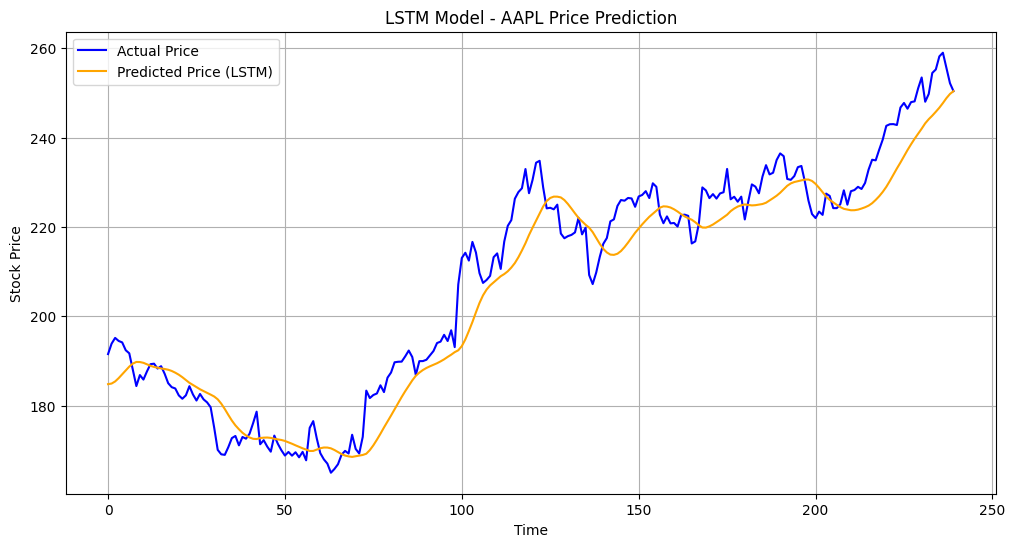

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price (LSTM)', color='orange')
plt.title('LSTM Model - AAPL Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAE: {mae:.4f}")

📊 MSE: 48.4285
📊 RMSE: 6.9591
📊 MAE: 5.5756
